# In this notebook 

# We perform kernal PCA from scratch and compare with sklearn's output.

# PCA to Kernel PCA

Let's say we have a data matrix or design matrix $X= \begin{bmatrix}  \pmb{x_1^T}\\ \vdots \\ \pmb{x_N^T}\end{bmatrix}$ where each observation $\pmb{x}_i \in \mathbb{R}^d$ is column vector.

To compute the PCA we can either compute eigen vectors or values of $X^TX$ or compute the eigen vectors $U$ and values $\Lambda$ of $XX^T.$ In the class, we showed that $X^TU$ and $\Lambda$ are eigen vectors and values of $X^TX$. We also showed that normalized eigen vectors $V$ are given by $X^TU\Lambda^{-1/2}$. We know that working with $XX^T$ allows us to kernelize PCA as dot product is between observations $\pmb{x_i}$.

Given kernel function $k$, let $K = \begin{bmatrix}  k(\pmb{x_1}, \pmb{x_1})   & k(\pmb{x_1}, \pmb{x_2}) &\cdots & k(\pmb{x_1}, \pmb{x_N})
\\  \vdots \\
k(\pmb{x_N}, \pmb{x_1})   & k(\pmb{x_N}, \pmb{x_2}) &\cdots & k(\pmb{x_N}, \pmb{x_N}) \end{bmatrix}$  be the Gram matrix.

From mercer theorem, we know that use of kernel implies an underlying feature space and function $\phi$, where we implicitly map point $\pmb{x_i}$ using this function as $\phi(\pmb{x_i})$.


Let $\pmb{\Phi}= \begin{bmatrix}  \phi(\pmb{x_1}^T)\\
\vdots \\
\phi(\pmb{x_N})^T
\end{bmatrix}$ be the corresponding design matrix after mapping points via $\phi$. This design matrix in mapped feature space is for conceptual understanding. We never build this in practice. 

<br>
Then $\pmb{\Phi \Phi^T} =\begin{bmatrix}
\phi(\pmb{x_1})^T\phi(\pmb{x_1})   & \phi(\pmb{x_1})^T\phi(\pmb{x_2}) &\cdots & \phi(\pmb{x_1})^T\phi(\pmb{x_N})\\
\vdots \\
\phi(\pmb{x_N})^T\phi(\pmb{x_1})   & \phi(\pmb{x_N})^T\phi(\pmb{x_2}) &\cdots & \phi(\pmb{x_N})^T\phi(\pmb{x_N})
\end{bmatrix} = $ is same as our

gram matrix $K$ as $ \phi(\pmb{x_i})^T\phi(\pmb{x_j})$ = $k(\pmb{x_i},\pmb{x_j})$.

Hence by analogy $V_{kpca} = \bf{\Phi}^T U \Lambda^{-1/2}$ where $U$ and $\Lambda$ are eigen value and vector of $K$. We proved in the class $\pmb{\Lambda}^{-1/2}$ is required to normalize eigen vector to unit length.

<font color ="red">Note that we never build(in some situation can't build) $\bf{\Phi}$. </font>

Hence we have the kernel principle component along the column of $V_{kpca}.$ 

Clearly we don't care about actual principle components in the feature space. We only want to calculate the projections along different principle component directions.

Let's say $\pmb{x_t}$ is a test vector in input space. Then we  can take the dot product of $\phi(x_t)$ with columns of $V_{kpca}$ to compute the projection as

$\phi(\pmb{x_t})^T V_{kpca} = \phi{(\pmb{x_t})}^T\bf{\Phi}^T U \Lambda^{-1/2} = \begin{bmatrix} \phi(\pmb{x_t})^T\phi(\pmb{x_1})  &\cdots & \phi(\pmb{x_t})^T\phi(\pmb{x_N}) \end{bmatrix} U \Lambda^{-1/2} =\begin{bmatrix} k(\pmb{x_t, x_1}) & \cdots & k(\pmb{x_t, x_N}) \end{bmatrix} U \Lambda^{-1/2} $

Hence if we have $N^*$ test point then we can store their interaction(dot product) with  each $\{ \pmb{x_i}\}_i^{N}$ in matrix $K^*_{N^* \times N}$.
 Projection into $L$ principle components can be calculated as 

 $K^* [U \Lambda^{-1/2}](:,:L) $ (selecting only $L$ column from $U \Lambda^{-1/2})$
 
 <font color ="megneta"> Can you convince yourself that if we want to calculate projection of all the input points $\{\bf{x_1}, \cdots, \bf{x_N} \}$ then $K^*=K$ hence projection is given by $U\Lambda^{1/2} ?$  </font> 
 
 
 
Everything is ok in above analysis but rememebr we forget to center the features in the feature space hence we work with $\bar{K} = HKH$ matrix where $H= I -\frac{1}{N}1_N1_N^T$ is the centering matrix. $I$ is $N\times N$ identity matrix and $1_N$ is vector of 1 of length $N$.

## Here is the final kernel PCA algorithm. 



- Input: Gram matrix $K_{N\times N}$, $K^*$ of size $N^* \times K$ and projection dim $L$.
- Build $H= I -\frac{1}{N}1_N1_N^T$ and compute centralized $\bar{K} = HKH= K- OK- KO +OKO$ where $O=\frac{1}{N}1_N1_N^T $
- $[U, \Lambda]$ = eig($\bar{K}$)
- Build $K*=\frac{1}{N^*}1_N1_N^T$ and compute centralized $\bar{K^*}  = K^*- O^*K^*- K^*O^* +O^*K^*O^*$

- Compute projection $ \bar{K^*}[U \Lambda^{-1/2}](:,:L) $



Let' Try Kernel PCA on following dataset. It should convince you about non linear PCA.

This is a circle dataset in sklearn. Read in sklearn about this dataset.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


Shape of X is (1000, 2)


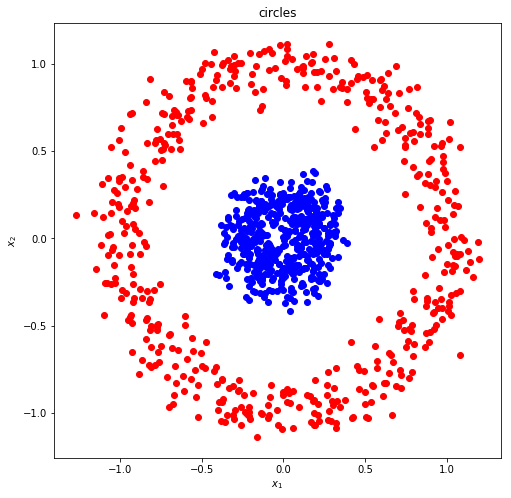

In [0]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)

plt.figure(figsize=(8,8))
print('Shape of X is {}'.format(X.shape))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red' )
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue')
plt.title('circles')
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.show()

Let' use RBF kernel to do kernel PCA

RBF kernel $k$ is defined as

$k(\pmb{x}_1, \pmb{x}_2) = exp(-\gamma \|\pmb{x}_i - \pmb{x}_j \|_2^2)$



# Building function to calculate RBF kernel

In [0]:
import math
def rbf_kernel(x_i, x_j, gamma = 5.0):
    k=math.exp(-gamma*np.dot(np.transpose(x_i-x_j),x_i-x_j))
    return k  

# Building function to calculate Gram matrix for any given kernel function

In [0]:
def gram_matrix(X, kernel_fn = rbf_kernel):
    '''
    input X: Input point in X along rows
    kernel_fn: kernel function to apply, default rbf
    '''
     # Finish code to return the gram matrix corresponding to kernel kernel_fn  
    d = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            d[i,j]=kernel_fn(X[i,:],X[j,:])
    return d

Let's compute centralizing matrix $H$

# Building matrix H. Look at the start for the definition.

In [0]:
I=np.identity(X.shape[0])
one=np.ones((X.shape[0],1))
kstar=np.dot(one,np.transpose(one))
k_star=(1/X.shape[0])*kstar
H=I-k_star
print(H.shape)
print(H)

(1000, 1000)
[[ 0.999 -0.001 -0.001 ... -0.001 -0.001 -0.001]
 [-0.001  0.999 -0.001 ... -0.001 -0.001 -0.001]
 [-0.001 -0.001  0.999 ... -0.001 -0.001 -0.001]
 ...
 [-0.001 -0.001 -0.001 ...  0.999 -0.001 -0.001]
 [-0.001 -0.001 -0.001 ... -0.001  0.999 -0.001]
 [-0.001 -0.001 -0.001 ... -0.001 -0.001  0.999]]


# Computing gram matrix and centralized gram matrix

In [0]:
K=gram_matrix(X)
K_cent=np.linalg.multi_dot([H,K,H])
#print(K.shape)
#print(K_cent.shape)
print(K_cent)

[[ 1.07156148  0.07554416  0.05417336 ...  0.06356913  0.05995797
  -0.22297341]
 [ 0.07554416  1.0513467   0.04201076 ...  0.05346175  0.04985113
  -0.22168239]
 [ 0.05417336  0.04201076  1.03267194 ...  0.04413867  0.04051379
  -0.23550169]
 ...
 [ 0.06356913  0.05346175  0.04413867 ...  1.05557678  0.46325538
  -0.23682273]
 [ 0.05995797  0.04985113  0.04051379 ...  0.46325538  1.04835446
  -0.2394916 ]
 [-0.22297341 -0.22168239 -0.23550169 ... -0.23682273 -0.2394916
   0.46779236]]


# Computing the projection of X into first two principle component direction in the feature space.

Note: that you have to compute eigen value and vector decomposition of centralized matrix and arrange from largest to smallest  eigen value and corresponding eigen vector.
 

In [0]:
eigVal,eigVect=np.linalg.eig(K_cent)
eigVal_root=np.sqrt(eigVal)
eigVal_root=np.diag(eigVal_root)
X_proj= np.dot(eigVect,eigVal_root[:,:2])

# Ploting the first two principle components. Using y values to color code the points.

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


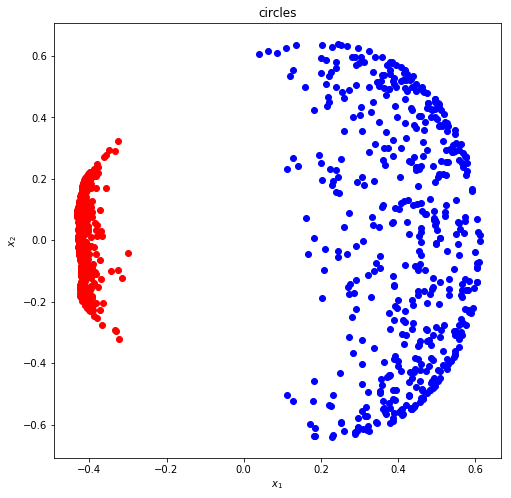

In [0]:
plt.figure(figsize=(8,8))
#print('Shape of X is {}'.format(X.shape))

plt.scatter(X_proj[y==0, 0], X_proj[y==0, 1], color='red' )
plt.scatter(X_proj[y==1, 0], X_proj[y==1, 1], color='blue')
plt.title('circles')
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.show()

# Ploting the first principle component. Use y values to  color code the points. see plotting of points at the start. 

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


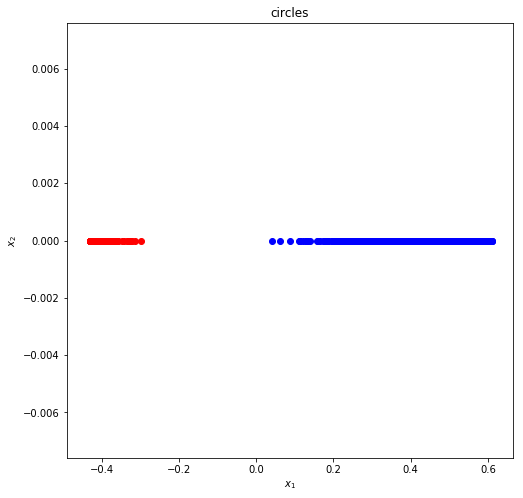

In [0]:
plt.figure(figsize=(8,8))
#print('Shape of X is {}'.format(X.shape))

plt.scatter(X_proj[y==0, 0], np.zeros(X_proj[y==0, 0].shape), color='red' )
plt.scatter(X_proj[y==1, 0], np.zeros(X_proj[y==1, 0].shape), color='blue')
plt.title('circles')
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.show()

Let's compare with Linear PCA

# Using PCA from sklearn to compute projection into first two principle component.

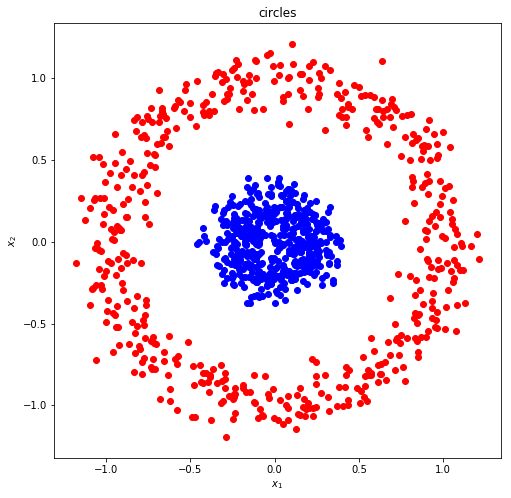

In [0]:
from sklearn.decomposition import PCA,KernelPCA
pca=PCA(n_components = 2)
X_pca=pca.fit_transform(X)
plt.figure(figsize=(8,8))
#print('Shape of X is {}'.format(X.shape))

plt.scatter(X_pca[y==0, 0], X_pca[y==0, 1], color='red' )
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], color='blue')
plt.title('circles')
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.show()

# Plotting only first principle component.

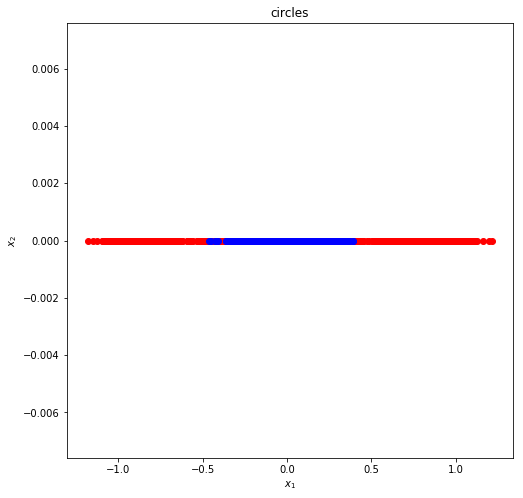

In [0]:
pca2=PCA(n_components = 1)
X_pca=pca2.fit_transform(X)
plt.figure(figsize=(8,8))
#print('Shape of X is {}'.format(X.shape))

plt.scatter(X_pca[y==0, 0], np.zeros(X_pca[y==0, 0].shape), color='red' )
plt.scatter(X_pca[y==1, 0], np.zeros(X_pca[y==1, 0].shape), color='blue')
plt.title('circles')
plt.ylabel('$x_2$')
plt.xlabel('$x_1$')
plt.show()

## Here is a sample output from kernel PCA from sklearn

In [0]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=2, kernel='rbf', gamma= 5.0)
projection = kpca.fit_transform(X)
projection.shape

(1000, 2)

Shape of X is (1000, 2)


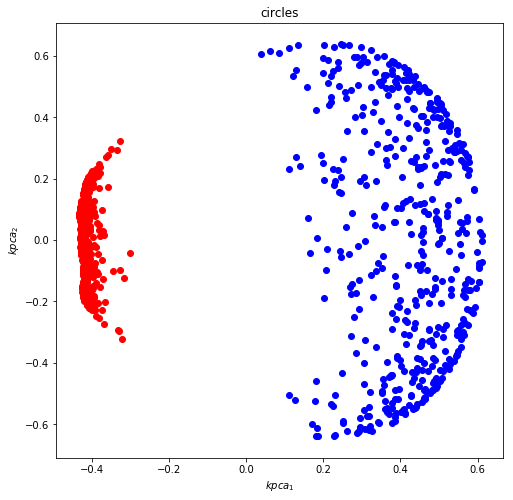

In [0]:
plt.figure(figsize=(8,8))
print('Shape of X is {}'.format(X.shape))

plt.scatter(projection[y==0, 0], projection[y==0, 1], color='red' )
plt.scatter(projection[y==1, 0], projection[y==1, 1], color='blue')
plt.title('circles')
plt.ylabel('$kpca_2$')
plt.xlabel('$kpca_1$')
plt.show()